Basic example of how to viusualize feature maps in convolutional neural nets.

3 different examples of cnn's, being used for 3 different datasets:
* MNIST
* Fashion MNIST
* CINIC-10

In [1]:
from keras.utils import np_utils
from src.models import *
from src.viz import *
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Function to fetch data and build models 
# for the MNIST and Fashion MNIST datasets
def run_mnist(name, epochs=10, cnn=False, dataset=mnist):
    (x_train, y_train), (x_test, y_test) = dataset.load_data()
    # Set input shape and reshape dataset
    input_shape = (28, 28, 1)
    if cnn:
        x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32')
        x_test = x_test.reshape(x_test.shape[0], 28, 28, 1).astype('float32')     
    else:
        num_pixels = x_train.shape[1] * x_train.shape[2]
        x_train = x_train.reshape(x_train.shape[0], num_pixels).astype('float32')
        x_test = x_test.reshape(x_test.shape[0], num_pixels).astype('float32')
    
    # Scale values from [0, 255] to [0, 1]
    x_train = x_train / 255
    x_test = x_test / 255
    
    # One-hot encode the target labels
    y_train = np_utils.to_categorical(y_train)
    y_test = np_utils.to_categorical(y_test)
    num_classes = y_test.shape[1]
    
    # Build model
    model = create_model(name, input_shape, num_classes)
    print_model(model,f"img/{name}.png")
    
    # Train the model
    tensorboard = TensorBoard(log_dir=f'logs/{name}')
    checkpoint = ModelCheckpoint(filepath=f"models/{name}.hdf5", 
                                 monitor = 'val_accuracy', 
                                 verbose=1, 
                                 save_best_only=True)
    callbacks = [tensorboard, checkpoint, ReduceLROnPlateau()]
    history = model.fit(x_train, y_train, 
                        validation_data=(x_test, y_test), 
                        epochs=epochs, 
                        batch_size=200,
                        verbose=1,
                        callbacks=callbacks
                        )
    
    plot_history_metrics(history, ['accuracy', 'loss'])
    
    return history, model

# Generators and function for models working with CINIC-10 dataset
PATH='../data/CINIC-10/'

batch_size = 32
target_size = (64, 64)

train_gen = ImageDataGenerator(rescale=1./255)
test_gen = ImageDataGenerator(rescale=1./255)

train_set = train_gen.flow_from_directory(PATH+'/train',
                                          batch_size=batch_size,
                                          target_size=target_size,
                                          class_mode='categorical')

test_set = test_gen.flow_from_directory(PATH+'/test',
                                        batch_size=batch_size,
                                        target_size=target_size,
                                        class_mode='categorical')

def run_cinic10(name, train_set, valid_set,
                epochs=10, lr=0.001):
    model = create_model(name, 
                         (target_size[0], target_size[1], 3), 
                         10, 
                         epochs=epochs, 
                         lr=lr
                         )
    print(model.summary())
    print_model(model, f"img/{name}.png")
    
    # Train the model
    tensorboard = TensorBoard(log_dir=f'logs/{name}')
    
    if lr == True:
        callbacks = [tensorboard, ReduceLROnPlateau()]
    else:
        callbacks = [tensorboard]
    checkpoint = ModelCheckpoint(filepath=f"models/{name}.hdf5", 
                                 monitor = 'val_accuracy', 
                                 verbose=1, 
                                 save_best_only=True)
    callbacks.append(checkpoint)
    history = model.fit(train_set,
                                  validation_data=valid_set, 
                                  epochs=epochs,
                                  verbose=1,
                                  callbacks=callbacks)
    
    plot_history_metrics(history, ['accuracy', 'loss'])
    return history, model

Using TensorFlow backend.


Found 90000 images belonging to 10 classes.
Found 90000 images belonging to 10 classes.


Train on 60000 samples, validate on 10000 samples
Epoch 1/25
59600/60000 [============================>.] - ETA: 0s - loss: 0.3941 - accuracy: 0.8776
Epoch 00001: val_accuracy improved from -inf to 0.97290, saving model to models/mnist_cnn_v2.hdf5
60000/60000 [==============================] - 12s 205us/sample - loss: 0.3920 - accuracy: 0.8782 - val_loss: 0.0853 - val_accuracy: 0.9729
Epoch 2/25
59600/60000 [============================>.] - ETA: 0s - loss: 0.0989 - accuracy: 0.9704
Epoch 00002: val_accuracy improved from 0.97290 to 0.98450, saving model to models/mnist_cnn_v2.hdf5
60000/60000 [==============================] - 8s 132us/sample - loss: 0.0986 - accuracy: 0.9705 - val_loss: 0.0495 - val_accuracy: 0.9845
Epoch 3/25
59600/60000 [============================>.] - ETA: 0s - loss: 0.0741 - accuracy: 0.9772
Epoch 00003: val_accuracy improved from 0.98450 to 0.98830, saving model to models/mnist_cnn_v2.hdf5
60000/60000 [==============================] - 6s 104us/sample - loss: 

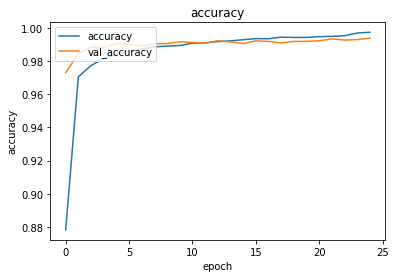

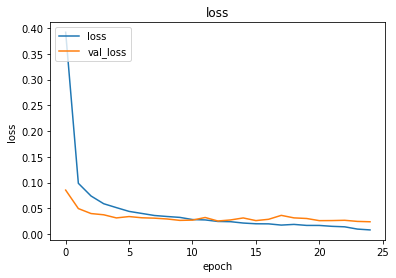

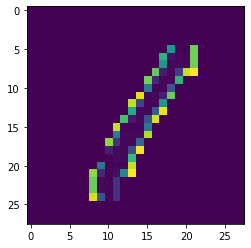

Prediction probabilities: 
[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]
Predicted class: 
[1]
Activations of Convolutional and Pooling layers:


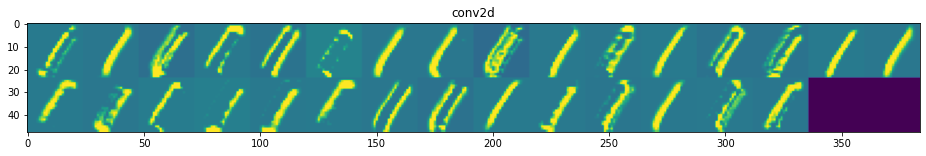

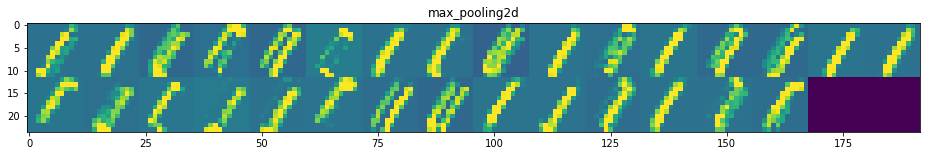

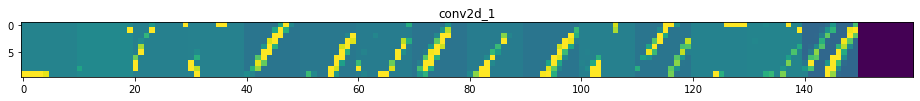

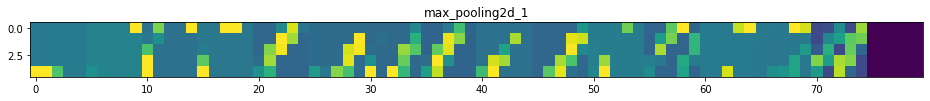

In [2]:
# Name of the model we will be using (defined in models.py)
name = 'mnist_cnn_v2'
mnist_hist, model = run_mnist(name, cnn=True, epochs=25)
model.load_weights(f'models/{name}.hdf5')
(x_train, _), _ = mnist.load_data()

act_model, layer_names = layer_outputs_model(model)
visualize_prediction(model, x_train, 3, act_model, layer_names)

Train on 60000 samples, validate on 10000 samples
Epoch 1/25
59800/60000 [============================>.] - ETA: 0s - loss: 0.5325 - accuracy: 0.8059
Epoch 00001: val_accuracy improved from -inf to 0.33890, saving model to models/mnist_cnn_v3.hdf5
60000/60000 [==============================] - 20s 329us/sample - loss: 0.5320 - accuracy: 0.8061 - val_loss: 2.1596 - val_accuracy: 0.3389
Epoch 2/25
59800/60000 [============================>.] - ETA: 0s - loss: 0.3254 - accuracy: 0.8803
Epoch 00002: val_accuracy improved from 0.33890 to 0.87160, saving model to models/mnist_cnn_v3.hdf5
60000/60000 [==============================] - 20s 337us/sample - loss: 0.3251 - accuracy: 0.8804 - val_loss: 0.3511 - val_accuracy: 0.8716
Epoch 3/25
59800/60000 [============================>.] - ETA: 0s - loss: 0.2814 - accuracy: 0.8957
Epoch 00003: val_accuracy improved from 0.87160 to 0.89840, saving model to models/mnist_cnn_v3.hdf5
60000/60000 [==============================] - 21s 345us/sample - loss

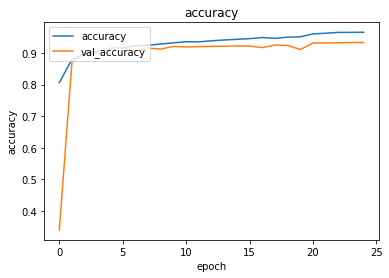

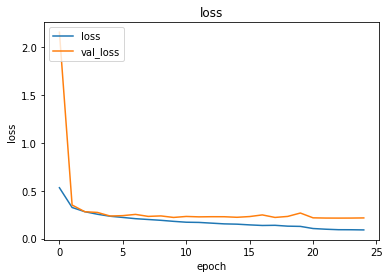

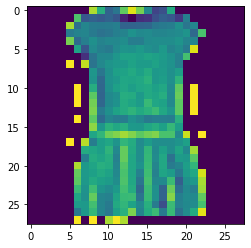

Prediction probabilities: 
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Predicted class: 
[0]
Activations of Convolutional and Pooling layers:


/home/random/Desktop/deep-learning-basics/src/viz.py:117: RuntimeWarning: invalid value encountered in true_divide
  picture /= picture.std()


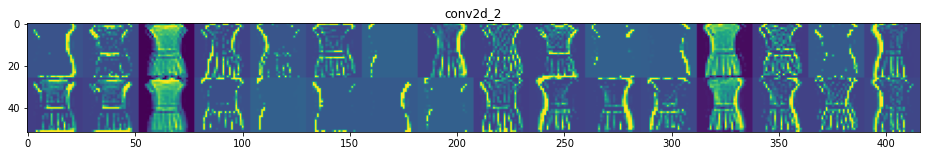

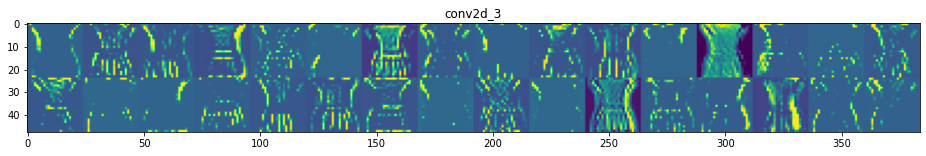

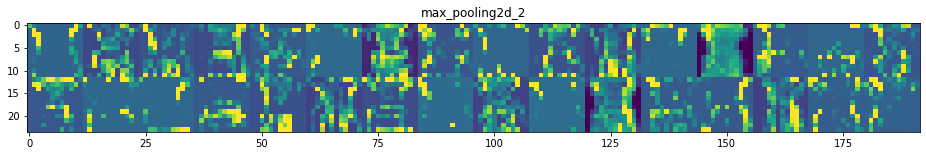

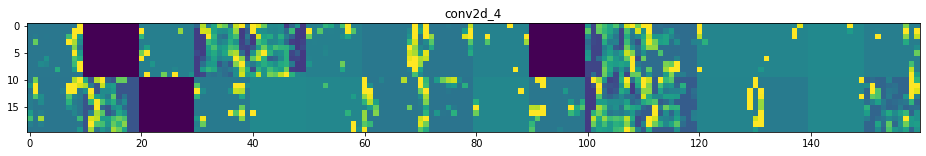

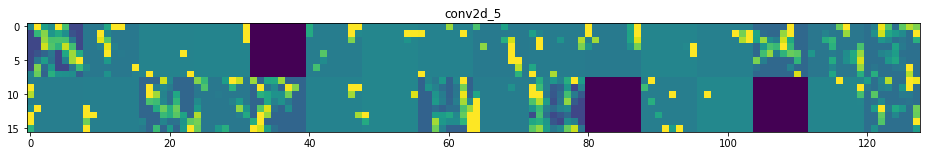

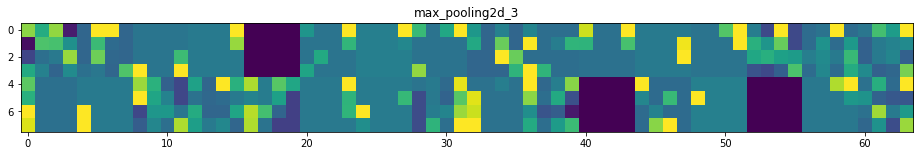

In [3]:
name = 'mnist_cnn_v3'
fashion_hist, model = run_mnist(name, cnn=True, epochs=25, dataset=fashion_mnist)
model.load_weights(f'models/{name}.hdf5')
(x_train, _), _ = fashion_mnist.load_data()

act_model, layer_names = layer_outputs_model(model)
visualize_prediction(model, x_train, 3, act_model, layer_names)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        2432      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 32)        25632     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0

2812/2813 [============================>.] - ETA: 0s - loss: 0.5602 - accuracy: 0.7992
Epoch 00014: val_accuracy improved from 0.71722 to 0.72024, saving model to models/cinic_v3.hdf5
2813/2813 [==============================] - 446s 159ms/step - loss: 0.5603 - accuracy: 0.7992 - val_loss: 0.8131 - val_accuracy: 0.7202
Epoch 15/25
2812/2813 [============================>.] - ETA: 0s - loss: 0.5478 - accuracy: 0.8044
Epoch 00015: val_accuracy improved from 0.72024 to 0.72763, saving model to models/cinic_v3.hdf5
2813/2813 [==============================] - 411s 146ms/step - loss: 0.5479 - accuracy: 0.8044 - val_loss: 0.7979 - val_accuracy: 0.7276
Epoch 16/25
2812/2813 [============================>.] - ETA: 0s - loss: 0.5331 - accuracy: 0.8091
Epoch 00016: val_accuracy did not improve from 0.72763
2813/2813 [==============================] - 399s 142ms/step - loss: 0.5331 - accuracy: 0.8091 - val_loss: 0.8087 - val_accuracy: 0.7238
Epoch 17/25
2812/2813 [============================>.] 

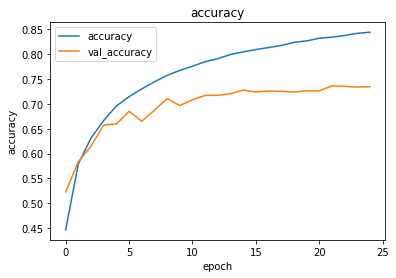

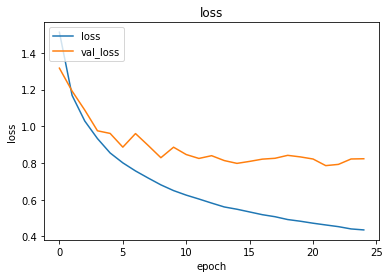

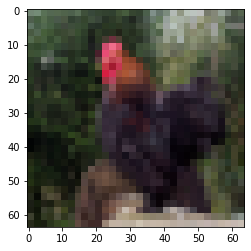

Prediction probabilities: 
[[0.00324577 0.00094205 0.56760806 0.01660627 0.28295824 0.08531717
  0.00331775 0.03314386 0.00097582 0.00588507]]
Predicted class: 
['bird']
Activations of Convolutional and Pooling layers:


/home/random/Desktop/deep-learning-basics/src/viz.py:117: RuntimeWarning: invalid value encountered in true_divide
  picture /= picture.std()


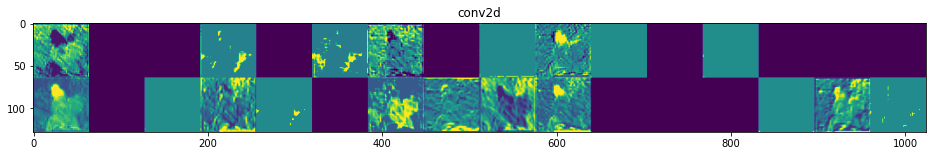

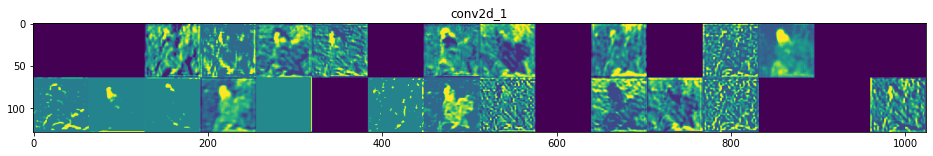

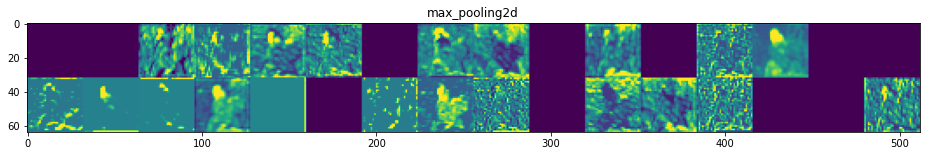

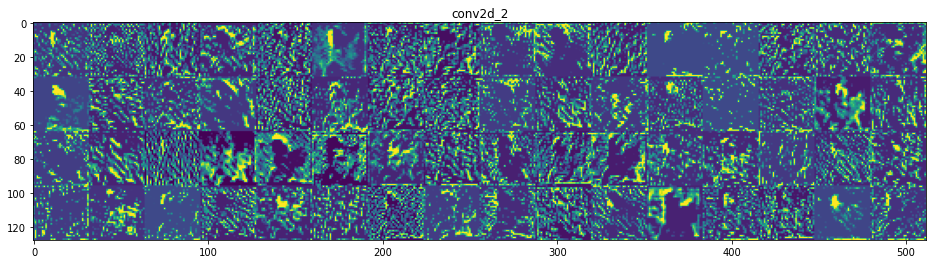

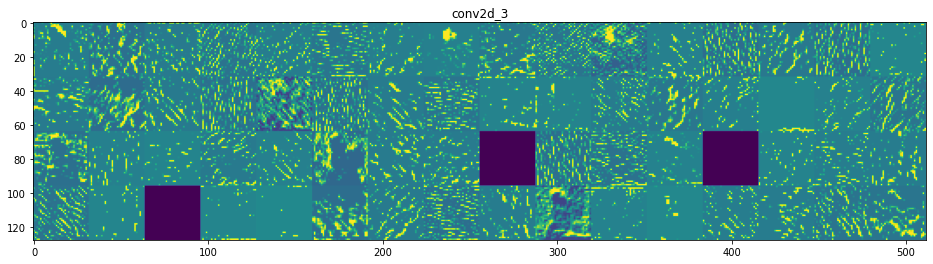

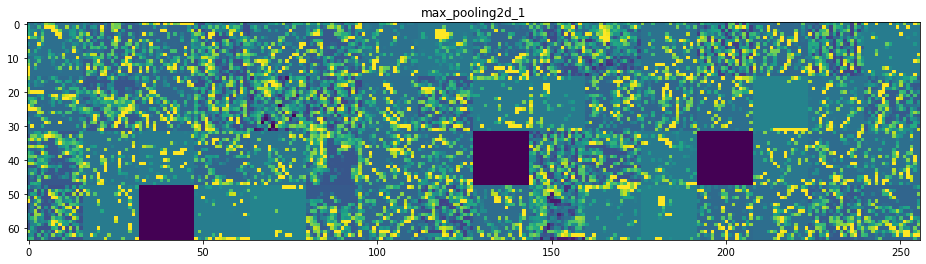

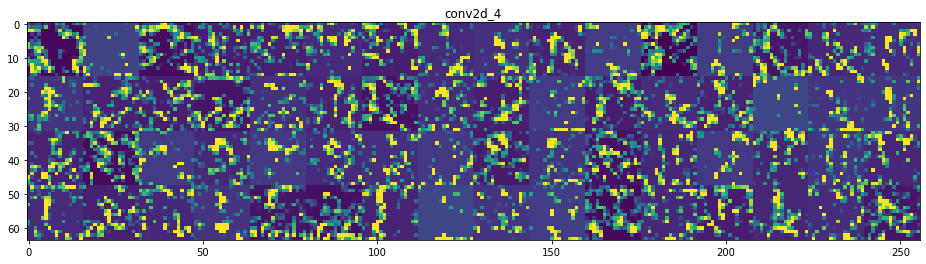

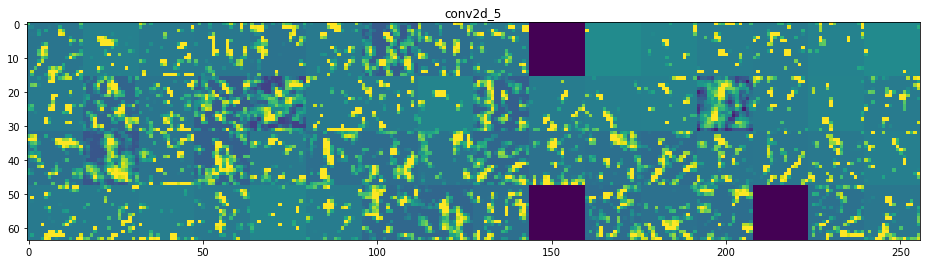

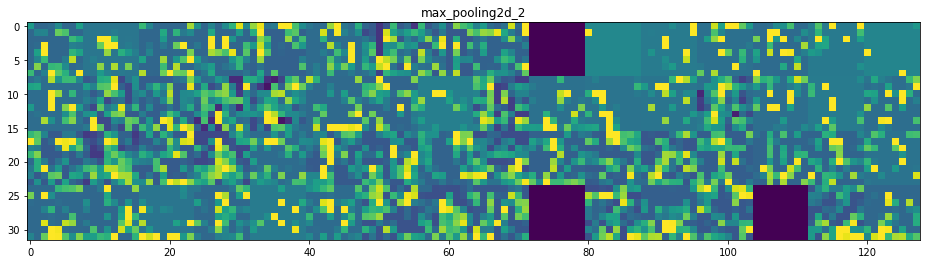

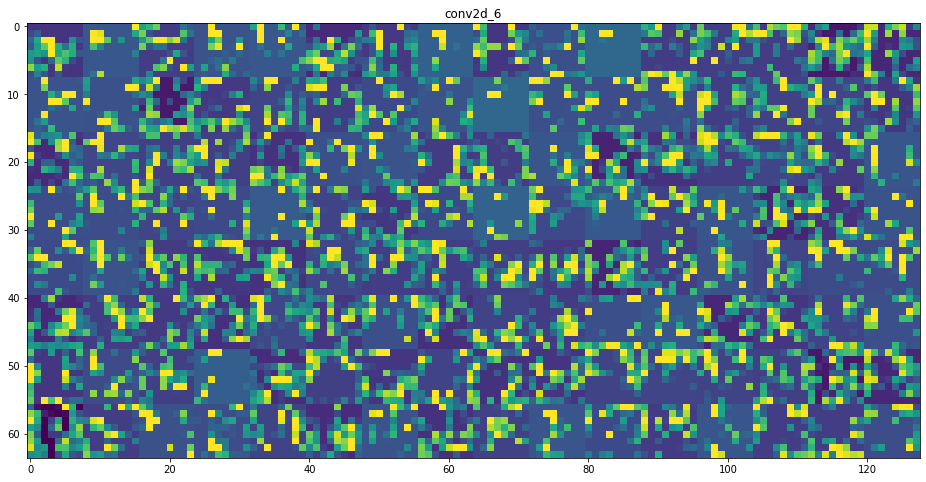

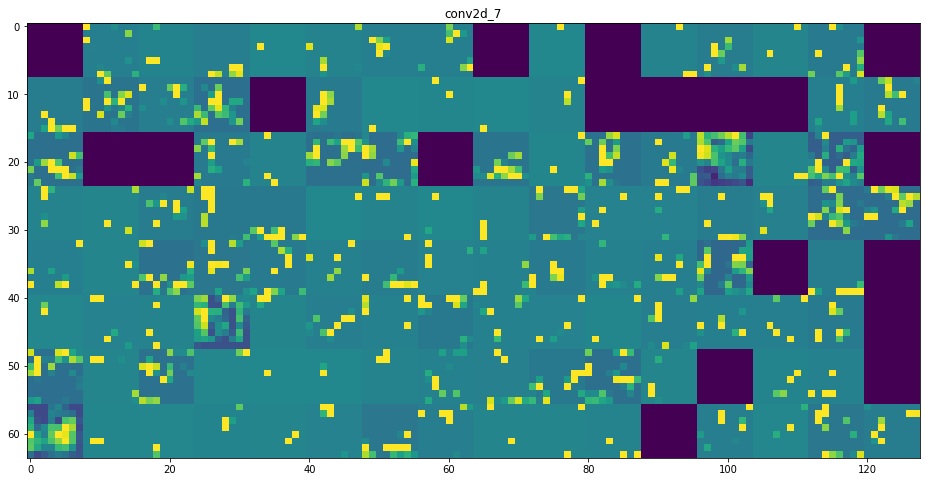

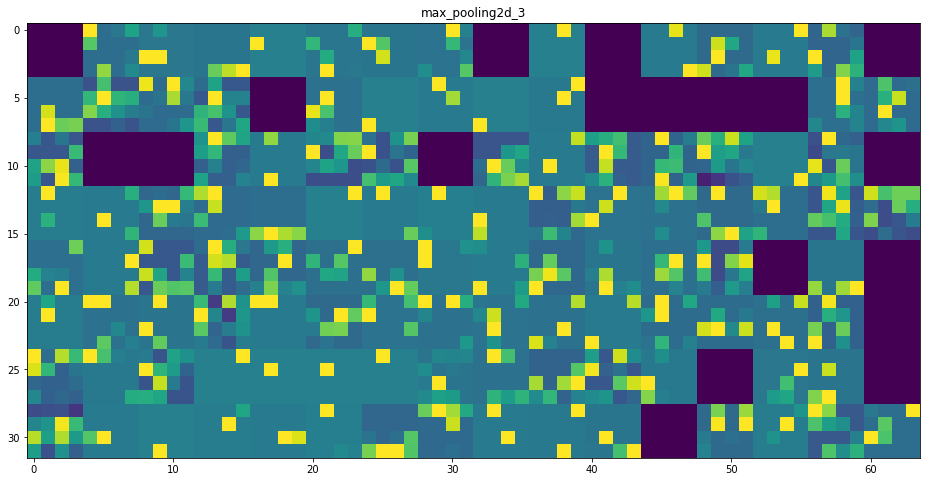

In [2]:
name = 'cinic_v3'
cinic_history, model = run_cinic10(name, train_set, test_set, epochs=25, lr=True)
model.load_weights(f'models/{name}.hdf5')

act_model, layer_names = layer_outputs_model(model)
visualize_prediction(model, 
                     train_set[0][0], 3, 
                     act_model, layer_names, 
                     labels=list(train_set.class_indices.keys()))